In [21]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

Number of train images : 3662 



In [23]:
No_images_per_class = []
Class_name = []
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 

Number of images in No_DR = 1805 



In [24]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

,Image,Labels
0,train/Mild/2d7666b8884f.png,Mild
1,train/Mild/50840c36f0b4.png,Mild
2,train/Mild/30cab14951ac.png,Mild
3,train/Mild/a8582e346df0.png,Mild
4,train/Mild/cab3dfa7962d.png,Mild
...,...,...
3657,train/No_DR/6b30767595d8.png,No_DR
3658,train/No_DR/2b4c7b5f1f1e.png,No_DR
3659,train/No_DR/ab78a66dee6a.png,No_DR
3660,train/No_DR/79ade634c633.png,No_DR


In [25]:
retina_df = shuffle(retina_df)

# Split the shuffled data into training and testing sets (80% train, 20% test)
train, test = train_test_split(retina_df, test_size=0.2)

In [11]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):
        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping=False):
        if not is_cropping:
            return img
        mask = img > self.tol
        return img[np.ix_(mask.any(1), mask.any(0))]

    def cropping_3D(self, img, is_cropping=False):
        if not is_cropping:
            return img
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > self.tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur=False):
        if not is_gaussianblur:
            return img
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), self.sigmaX), -4, 128)
        return img

    def draw_circle(self, img, is_drawcircle=True):
        if not is_drawcircle:
            return img
        x = int(self.img_width / 2)
        y = int(self.img_height / 2)
        r = np.amin((x, y))
        circle_img = np.zeros((self.img_height, self.img_width), np.uint8)
        cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping=True, is_gaussianblur=True, is_drawcircle=True):
        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)
        else:
            img = self.cropping_3D(img, is_cropping)
        img = cv2.resize(img, (self.img_width, self.img_height), interpolation=cv2.INTER_AREA)
        if is_drawcircle:
            img = self.draw_circle(img)
        if is_gaussianblur:
            img = self.Gaussian_blur(img)
        return img

# Instantiate your preprocessing class
preprocessor = ImageProcessing(256, 256, 3)

# Update your ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocessor.image_preprocessing,  # Add custom preprocessing function
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale = 1./255,preprocessing_function=preprocessor.image_preprocessing)

# Use this updated generator to load data
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


In [15]:
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.6318 - loss: 1.5363
Epoch 1: val_loss improved from inf to 1.29510, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 778ms/step - accuracy: 0.6317 - loss: 1.5360 - val_accuracy: 0.5900 - val_loss: 1.2951
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.6128 - loss: 1.5086
Epoch 2: val_loss improved from 1.29510 to 1.19913, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 771ms/step - accuracy: 0.6127 - loss: 1.5085 - val_accuracy: 0.6378 - val_loss: 1.1991
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.6033 - loss: 1.4577
Epoch 3: val_loss did not improve from 1.19913
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 755ms/step - accuracy: 0.6030 - loss: 1.4577 - val_accuracy: 0.5695 - val_loss: 1.3885
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6143 - loss: 1.4265
Epoch 4: val_loss did not improve from 1.19913
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 773ms/step - accuracy

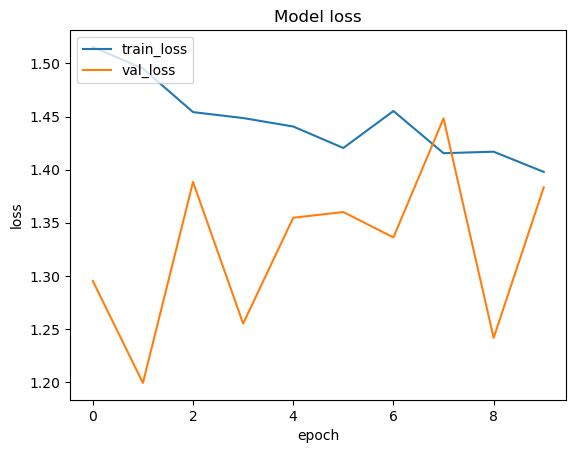

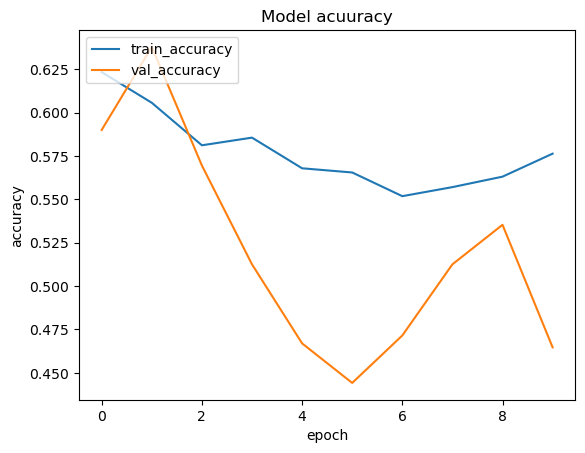

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acuuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'upper left')
plt.show()

In [17]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.6896 - loss: 1.1049
Accuracy Test : 0.6775568127632141
